In [ ]:
!pip install transformers datasets peft

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install seaborn

In [ ]:
!pip install transformers datasets peft accelerate

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/empathetic_dialogues")

# Function to clean the data
def preprocess(example):
    # Replace "_comma_" with ", " in the utterance column
    if example["utterance"] is not None:  # Check for null values
        example["utterance"] = example["utterance"].replace("_comma_", ",")
        example["prompt"] = example["prompt"].replace("_comma_", ",")
    return example

# Apply preprocessing
dataset = dataset.map(preprocess)

# Function to remove null values
def remove_null(example):
    return example["utterance"] is not None  # Keep only non-null utterances

# Apply filtering to remove null values
dataset = dataset.filter(remove_null)

# Display an example after preprocessing
print(dataset["train"][0:8])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

The repository for facebook/empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Map:   0%|          | 0/12030 [00:00<?, ? examples/s]

Map:   0%|          | 0/10943 [00:00<?, ? examples/s]

Filter:   0%|          | 0/76673 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12030 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10943 [00:00<?, ? examples/s]

{'conv_id': ['hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:1_conv:2', 'hit:1_conv:2'], 'utterance_idx': [1, 2, 3, 4, 5, 6, 1, 2], 'context': ['sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'afraid', 'afraid'], 'prompt': ['I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
#dataset = load_dataset("daily_dialog")

# Convert train and test splits to Pandas DataFrames
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Display the first few rows
print(df_train.head())
print(df_train.columns)  # Check column names

        conv_id  utterance_idx      context  \
0  hit:0_conv:1              1  sentimental   
1  hit:0_conv:1              2  sentimental   
2  hit:0_conv:1              3  sentimental   
3  hit:0_conv:1              4  sentimental   
4  hit:0_conv:1              5  sentimental   

                                              prompt  speaker_idx  \
0  I remember going to the fireworks with my best...            1   
1  I remember going to the fireworks with my best...            0   
2  I remember going to the fireworks with my best...            1   
3  I remember going to the fireworks with my best...            0   
4  I remember going to the fireworks with my best...            1   

                                           utterance     selfeval tags  
0  I remember going to see the fireworks with my ...  5|5|5_2|2|5       
1  Was this a friend you were in love with, or ju...  5|5|5_2|2|5       
2                This was a best friend. I miss her.  5|5|5_2|2|5       
3         

In [ ]:
# Keep only rows that DO NOT contain "_conv:" in the utterances column
df_train = df_train[~df_train['utterance'].str.contains('_conv:')]
df_test = df_test[~df_test['utterance'].str.contains('_conv:')]
#df_train.reset_index(drop=True, inplace=True)


In [ ]:
# Check if any rows still have '_conv:'
df_train[df_train['utterance'].str.contains('_conv:')]
df_test[df_test['utterance'].str.contains('_conv:')]

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags


In [ ]:
df_train.to_csv('check.csv', index=False)


In [ ]:
# Check if any still exist
df_train[df_train['utterance'].str.match(pattern)]


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags


In [ ]:
from google.colab import files
files.download('check.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Assuming your dataframe is named df
# Step 1: Drop the 'selfeval' and 'tags' columns
df_train = df_train.drop(columns=['selfeval', 'tags'])
df_test = df_test.drop(columns=['selfeval', 'tags'])

def group_conversations(df):
    """
    Groups conversation data by 'conv_id'.

    Args:
        df (pd.DataFrame): Original dataframe containing conv_id, prompt, context, utterance_idx, and utterance.

    Returns:
        pd.DataFrame: Grouped dataframe with combined utterances and representative prompt/context.
    """
    grouped_df = (
        df.groupby('conv_id')
        .apply(lambda x: pd.Series({
            'prompt': x['prompt'].iloc[0],  # Take the first prompt
            'context': x['context'].iloc[0],  # Take the first context
            'utterances': ' '.join(x.sort_values('utterance_idx')['utterance'].astype(str))  # Combine utterances
        }))
        .reset_index()
    )
    return grouped_df

grouped_df_train = group_conversations(df_train)
grouped_df_test = group_conversations(df_test)

print(grouped_df_train.head())
print(grouped_df_test.head())



<ipython-input-24-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


                conv_id                                             prompt  \
0          hit:0_conv:1  I remember going to the fireworks with my best...   
1  hit:10000_conv:20000  My girlfriend got me a toad today! I was so sh...   
2  hit:10000_conv:20001       I really like the new paint job on my house.   
3  hit:10001_conv:20002  I went to the skating rink all by myself today...   
4  hit:10002_conv:20004  I was walking on the road. I saw beggar and i ...   

       context                                         utterances  
0  sentimental  I remember going to see the fireworks with my ...  
1    surprised  My girlfriend got me a pet toad today! Do you ...  
2    impressed  I really like the new paint job on my house. T...  
3       lonely  I went to the skating rink all by myself today...  
4      ashamed  I was walking on the road. I saw a beggar and ...  
                conv_id                                             prompt  \
0          hit:0_conv:0  I felt guilty when I

<ipython-input-24-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


In [ ]:
label_counts_train = grouped_df_train["context"].value_counts()
label_counts_test = grouped_df_test["context"].value_counts()
print(label_counts_train)
print(grouped_df_train.shape)
print(label_counts_test)
print(grouped_df_test.shape)

context
surprised       924
excited         683
proud           636
angry           636
annoyed         613
sad             609
grateful        586
lonely          585
afraid          584
terrified       578
anxious         571
guilty          571
disgusted       569
confident       566
hopeful         564
impressed       561
anticipating    561
furious         553
joyful          552
disappointed    549
nostalgic       542
prepared        536
jealous         535
content         516
devastated      514
embarrassed     511
caring          474
sentimental     473
trusting        453
ashamed         445
apprehensive    418
faithful        325
Name: count, dtype: int64
(17793, 4)
context
surprised       127
proud            96
grateful         95
excited          91
sentimental      91
annoyed          91
sad              88
disgusted        86
angry            84
joyful           83
disappointed     81
embarrassed      81
jealous          81
impressed        81
caring           80
hopeful

In [ ]:
from transformers import pipeline
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None    # updated from return_all_scores=True
)

def get_emotion_score(text):
    predictions = emotion_classifier(text)[0]
    max_prob = max([pred['score'] for pred in predictions])
    return round(max_prob * 10, 2)


#df_small['sentiment_score'] = df_small['utterances'].apply(get_emotion_score)
grouped_df_train['sentiment_score'] = grouped_df_train['utterances'].apply(get_emotion_score)
grouped_df_train.head()


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:1,I remember going to the fireworks with my best...,sentimental,I remember going to see the fireworks with my ...,4.11
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,surprised,My girlfriend got me a pet toad today! Do you ...,9.61
2,hit:10000_conv:20001,I really like the new paint job on my house.,impressed,I really like the new paint job on my house. T...,9.82
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,lonely,I went to the skating rink all by myself today...,8.29
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,ashamed,I was walking on the road. I saw a beggar and ...,5.43


In [ ]:
grouped_df_train.to_csv('grouped_df_train_with_scores.csv', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
grouped_df_train.to_excel('grouped_df_train_with_scores.xlsx', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.csv /content/drive/MyDrive/research


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.xlsx /content/drive/MyDrive/research

In [ ]:
grouped_df_test['sentiment_score'] = grouped_df_test['utterances'].apply(get_emotion_score)
grouped_df_test.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [ ]:
grouped_df_test.to_csv('grouped_df_test_with_scores.csv', index=False)
grouped_df_test.to_excel('grouped_df_test_with_scores.xlsx', index=False)

In [ ]:
files.download('grouped_df_test_with_scores.csv')
files.download('grouped_df_test_with_scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.csv /content/drive/MyDrive/research

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.xlsx /content/drive/MyDrive/research

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace with your actual file path
file_path_train = '/content/drive/MyDrive/research/grouped_df_train_with_scores.csv'
file_path_test = '/content/drive/MyDrive/research/grouped_df_test_with_scores.csv'

# Load the dataset
grouped_df_train = pd.read_csv(file_path_train)
grouped_df_test = pd.read_csv(file_path_test)

# Preview
grouped_df_train.head()
grouped_df_test.head()


Mounted at /content/drive


,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [ ]:
grouped_df_train.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:1,I remember going to the fireworks with my best...,sentimental,I remember going to see the fireworks with my ...,4.11
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,surprised,My girlfriend got me a pet toad today! Do you ...,9.61
2,hit:10000_conv:20001,I really like the new paint job on my house.,impressed,I really like the new paint job on my house. T...,9.82
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,lonely,I went to the skating rink all by myself today...,8.29
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,ashamed,I was walking on the road. I saw a beggar and ...,5.43


In [ ]:
emotion_base_model = ['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']

In [ ]:
print(emotion_base_model)

['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

def model_training_and_evaluation(emotion_list, grouped_df_train, grouped_df_test, model_type, tokenizer_name='bert-base-uncased', max_len=96):

    df_train_filtered = grouped_df_train[grouped_df_train['context'].isin(emotion_list)].reset_index(drop=True)
    df_test_filtered = grouped_df_test[grouped_df_test['context'].isin(emotion_list)].reset_index(drop=True)

    print(f"\nFiltered Training Samples: {len(df_train_filtered)}")
    print(f"Filtered Testing Samples: {len(df_test_filtered)}")

    # Step 2: Convert pandas DataFrames to HuggingFace Datasets
    hf_dataset_train = Dataset.from_pandas(df_train_filtered)
    hf_dataset_test = Dataset.from_pandas(df_test_filtered)

    # Step 3: Create label mapping based on filtered train dataset
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(hf_dataset_train["context"])))}

    print(f"Label Mapping for this pair: {label_mapping}")

    # Step 4: Define label encoder function
    def encode_labels(example):
        example["labels"] = label_mapping[example["context"]]
        return example

    # Step 5: Apply label encoding
    hf_dataset_train = hf_dataset_train.map(encode_labels)
    hf_dataset_test = hf_dataset_test.map(encode_labels)

    from transformers import AutoTokenizer
    import torch
    # Step 6: Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # Step 7: Tokenize utterances
    def tokenize_function(batch):
        return tokenizer(
            batch["utterances"],
            padding='max_length',
            truncation=True,
            max_length=max_len
        )

    tokenized_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
    tokenized_dataset_test = hf_dataset_test.map(tokenize_function, batched=True)


    tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_train[0:4])

    tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_test[0:4])

    from transformers import AutoTokenizer #DataCollatorWithPadding

    #data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    import torch
    #from transformers import DataCollatorWithPadding
    from torch.utils.data import DataLoader

    train_dataloader = DataLoader(
        tokenized_dataset_train,
        batch_size=16,
        shuffle=True,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    test_dataloader = DataLoader(
        tokenized_dataset_test,
        batch_size=16,
        shuffle= False,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    num_labels = len(label_mapping)

    class CustomBERTModel(nn.Module):
        def __init__(self, model_name, num_labels):
            super(CustomBERTModel, self).__init__()
            self.bert = AutoModel.from_pretrained(model_name)

            hidden_size = self.bert.config.hidden_size  # usually 768
            additional_feature_size = 1  # sentiment_score is a scalar

            self.dropout = nn.Dropout(0.3)

            self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

        def forward(self, input_ids, attention_mask, sentiment_score):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

            # Get [CLS] representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

            # Reshape sentiment_score to (batch_size, 1)
            sentiment_score = sentiment_score.unsqueeze(1)

            # Concatenate
            combined = torch.cat((pooled_output, sentiment_score), dim=1)

            # Dropout + classification
            combined = self.dropout(combined)
            logits = self.classifier(combined)

            return logits

    model_name = "bert-base-uncased"
    model = CustomBERTModel(model_name, num_labels)

    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.train()

    for epoch in range(1):  # Increase if needed
        total_loss = 0

        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sentiment_scores = batch["sentiment_score"].to(device)

            optimizer.zero_grad()

            # Forward pass with sentiment_score
            logits = model(input_ids=input_ids, attention_mask=attention_mask, sentiment_score=sentiment_scores)

            # Compute individual losses
            losses = criterion(logits, labels)

            # Normalize sentiment_scores if needed
            normalized_weights = sentiment_scores / sentiment_scores.max()

            # Apply weights
            weighted_losses = losses * normalized_weights
            loss = weighted_losses.mean()

            # Backprop and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}] complete. Average Loss: {avg_loss:.4f}")


    import torch
    import os
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Save dir (change emotion pair as needed)
    #emotion_pair = ('ashamed', 'guilty')
    save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{model_type}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model weights using torch
    model_save_path = os.path.join(save_dir, "pytorch_model.bin")
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizer the usual Hugging Face way
    tokenizer.save_pretrained(save_dir)

    print(f"Model weights saved to {model_save_path}")
    print(f"Tokenizer files saved to {save_dir}")


    # Switch to evaluation mode
    model.eval()

    # Track loss and predictions
    total_loss = 0
    all_predictions = []
    all_labels = []

    criterion = torch.nn.CrossEntropyLoss()  # Or use the same loss as during training if needed

    # No gradient calculation (faster inference)
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            sentiment_scores = batch["sentiment_score"]
            labels = batch["labels"]

            # Forward pass through your custom model
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                sentiment_score=sentiment_scores  # make sure this matches your forward signature
            )

            # Compute loss
            loss = criterion(logits, labels)

            # Store total loss
            total_loss += loss.item()

            # Get predicted labels (highest probability class)
            predictions = torch.argmax(logits, dim=-1)

            # Store labels and predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to tensors (optional since already numpy arrays)
    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    # Calculate average validation loss
    avg_loss = total_loss / len(test_dataloader)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Display results
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.show()




Filtered Training Samples: 17793
Filtered Testing Samples: 2540
Label Mapping for this pair: {'afraid': 0, 'angry': 1, 'annoyed': 2, 'anticipating': 3, 'anxious': 4, 'apprehensive': 5, 'ashamed': 6, 'caring': 7, 'confident': 8, 'content': 9, 'devastated': 10, 'disappointed': 11, 'disgusted': 12, 'embarrassed': 13, 'excited': 14, 'faithful': 15, 'furious': 16, 'grateful': 17, 'guilty': 18, 'hopeful': 19, 'impressed': 20, 'jealous': 21, 'joyful': 22, 'lonely': 23, 'nostalgic': 24, 'prepared': 25, 'proud': 26, 'sad': 27, 'sentimental': 28, 'surprised': 29, 'terrified': 30, 'trusting': 31}


Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

{'sentiment_score': tensor([4.1100, 9.6100, 9.8200, 8.2900]), 'labels': tensor([28, 29, 20, 23]), 'input_ids': tensor([[  101,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,  2026,
          2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,  2412,
          2985,  2051,  2894,  2362,  1012,  2348,  2045,  2001,  1037,  2843,
          1997,  2111,  1010,  2057,  2371,  2066,  1996,  2069,  2111,  1999,
          1996,  2088,  1012,  2001,  2023,  1037,  2767,  2017,  2020,  1999,
          2293,  2007,  1010,  2030,  2074,  1037,  2190,  2767,  1029,  2023,
          2001,  1037,  2190,  2767,  1012,  1045,  3335,  2014,  1012,  2073,
          2038,  2016,  2908,  1029,  2057,  2053,  2936,  2831,  1012,  2821,
          2001,  2023,  2242,  2008,  3047,  2138,  1997,  2019,  6685,  1029,
           102,     0,     0,     0,     0,     0],
        [  101,  2026,  6513,  2288,  2033,  1037,  9004, 21344,  2651,   999,
          2079,  2017,  2066, 21344,  2015,  10

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch [1], Batch [0], Loss: 2.5683
Epoch [1], Batch [10], Loss: 2.7467
Epoch [1], Batch [20], Loss: 2.6102
Epoch [1], Batch [30], Loss: 2.7791
Epoch [1], Batch [40], Loss: 2.6429
Epoch [1], Batch [50], Loss: 2.5392
Epoch [1], Batch [60], Loss: 2.6432
Epoch [1], Batch [70], Loss: 2.8888
Epoch [1], Batch [80], Loss: 2.6380
Epoch [1], Batch [90], Loss: 2.9983
Epoch [1], Batch [100], Loss: 2.3452
Epoch [1], Batch [110], Loss: 2.6615
Epoch [1], Batch [120], Loss: 2.1359
Epoch [1], Batch [130], Loss: 2.2164
Epoch [1], Batch [140], Loss: 2.2524
Epoch [1], Batch [150], Loss: 1.9267
Epoch [1], Batch [160], Loss: 1.6672
Epoch [1], Batch [170], Loss: 2.1173
Epoch [1], Batch [180], Loss: 2.3531
Epoch [1], Batch [190], Loss: 1.8829
Epoch [1], Batch [200], Loss: 1.4171
Epoch [1], Batch [210], Loss: 1.8553
Epoch [1], Batch [220], Loss: 1.9904
Epoch [1], Batch [230], Loss: 1.7264
Epoch [1], Batch [240], Loss: 1.7353
Epoch [1], Batch [250], Loss: 2.1286
Epoch [1], Batch [260], Loss: 1.9094
Epoch [1], B

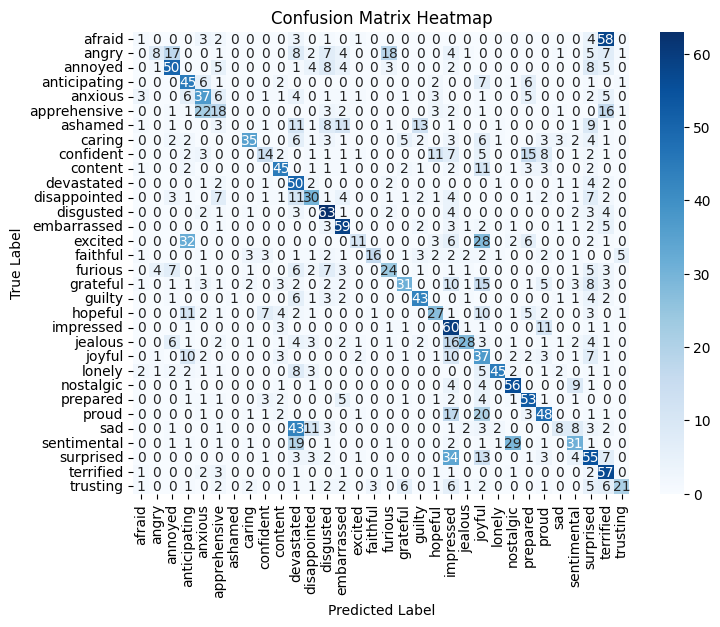

In [ ]:
model_training_and_evaluation(
    emotion_list= emotion_base_model,
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    model_type = "base_model",
    tokenizer_name='bert-base-uncased',
    max_len=96
)

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel



def prepare_emotion_pair_datasets(emotion_pair, grouped_df_train, grouped_df_test, tokenizer_name="bert-base-uncased", max_len=96):
    """
    Prepare datasets filtered by emotion pair for model training.

    Args:
        emotion_pair (tuple): A tuple of two emotions to filter, e.g., ('ashamed', 'guilty')
        grouped_df_train (pd.DataFrame): Training dataset with all emotions
        grouped_df_test (pd.DataFrame): Testing dataset with all emotions
        tokenizer_name (str): Pretrained tokenizer name from Hugging Face model hub
        max_len (int): Maximum token length for tokenizer

    Returns:
        tokenized_dataset_train (datasets.Dataset): Filtered and tokenized train dataset
        tokenized_dataset_test (datasets.Dataset): Filtered and tokenized test dataset
        label_mapping (dict): Mapping of emotions to numeric labels
    """

    # Unpack the emotion pair
    emotion_1, emotion_2 = emotion_pair

    # Step 1: Filter training and testing DataFrames based on the emotions
    emotion_misclassified = [emotion_1, emotion_2]
    df_train_filtered = grouped_df_train[grouped_df_train['context'].isin(emotion_misclassified)].reset_index(drop=True)
    df_test_filtered = grouped_df_test[grouped_df_test['context'].isin(emotion_misclassified)].reset_index(drop=True)

    print(f"\nFiltered Training Samples: {len(df_train_filtered)}")
    print(f"Filtered Testing Samples: {len(df_test_filtered)}")

    # Step 2: Convert pandas DataFrames to HuggingFace Datasets
    hf_dataset_train = Dataset.from_pandas(df_train_filtered)
    hf_dataset_test = Dataset.from_pandas(df_test_filtered)

    # Step 3: Create label mapping based on filtered train dataset
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(hf_dataset_train["context"])))}

    print(f"Label Mapping for this pair: {label_mapping}")

    # Step 4: Define label encoder function
    def encode_labels(example):
        example["labels"] = label_mapping[example["context"]]
        return example

    # Step 5: Apply label encoding
    hf_dataset_train = hf_dataset_train.map(encode_labels)
    hf_dataset_test = hf_dataset_test.map(encode_labels)

    from transformers import AutoTokenizer
    import torch
    # Step 6: Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # Step 7: Tokenize utterances
    def tokenize_function(batch):
        return tokenizer(
            batch["utterances"],
            padding='max_length',
            truncation=True,
            max_length=max_len
        )

    tokenized_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
    tokenized_dataset_test = hf_dataset_test.map(tokenize_function, batched=True)


    tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_train[0:4])

    tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_test[0:4])

    from transformers import AutoTokenizer #DataCollatorWithPadding

    #data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    import torch
    from transformers import DataCollatorWithPadding
    from torch.utils.data import DataLoader

    train_dataloader_stack = DataLoader(
        tokenized_dataset_train,
        batch_size=16,
        shuffle=True,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    test_dataloader_stack = DataLoader(
        tokenized_dataset_test,
        batch_size=16,
        shuffle= False,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    num_labels = len(label_mapping)

    class CustomBERTModel(nn.Module):
        def __init__(self, model_name, num_labels):
            super(CustomBERTModel, self).__init__()
            self.bert = AutoModel.from_pretrained(model_name)

            hidden_size = self.bert.config.hidden_size  # usually 768
            additional_feature_size = 1  # sentiment_score is a scalar

            self.dropout = nn.Dropout(0.3)

            self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

        def forward(self, input_ids, attention_mask, sentiment_score):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

            # Get [CLS] representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

            # Reshape sentiment_score to (batch_size, 1)
            sentiment_score = sentiment_score.unsqueeze(1)

            # Concatenate
            combined = torch.cat((pooled_output, sentiment_score), dim=1)

            # Dropout + classification
            combined = self.dropout(combined)
            logits = self.classifier(combined)

            return logits

    model_name = "bert-base-uncased"
    model = CustomBERTModel(model_name, num_labels)

    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.train()

    for epoch in range(3):  # Increase if needed
        total_loss = 0

        for batch_idx, batch in enumerate(train_dataloader_stack):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sentiment_scores = batch["sentiment_score"].to(device)

            optimizer.zero_grad()

            # Forward pass with sentiment_score
            logits = model(input_ids=input_ids, attention_mask=attention_mask, sentiment_score=sentiment_scores)

            # Compute individual losses
            losses = criterion(logits, labels)

            # Normalize sentiment_scores if needed
            normalized_weights = sentiment_scores / sentiment_scores.max()

            # Apply weights
            weighted_losses = losses * normalized_weights
            loss = weighted_losses.mean()

            # Backprop and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader_stack)
        print(f"Epoch [{epoch+1}] complete. Average Loss: {avg_loss:.4f}")


    import torch
    import os
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Save dir (change emotion pair as needed)
    #emotion_pair = ('ashamed', 'guilty')
    save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{emotion_pair[0]}_{emotion_pair[1]}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model weights using torch
    model_save_path = os.path.join(save_dir, "pytorch_model.bin")
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizer the usual Hugging Face way
    tokenizer.save_pretrained(save_dir)

    print(f"Model weights saved to {model_save_path}")
    print(f"Tokenizer files saved to {save_dir}")

    #import torch
    #from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    # Switch to evaluation mode
    model.eval()

    # Track loss and predictions
    total_loss = 0
    all_predictions = []
    all_labels = []

    criterion = torch.nn.CrossEntropyLoss()  # Or use the same loss as during training if needed

    # No gradient calculation (faster inference)
    with torch.no_grad():
        for batch in test_dataloader_stack:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            sentiment_scores = batch["sentiment_score"]
            labels = batch["labels"]

            # Forward pass through your custom model
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                sentiment_score=sentiment_scores  # make sure this matches your forward signature
            )

            # Compute loss
            loss = criterion(logits, labels)

            # Store total loss
            total_loss += loss.item()

            # Get predicted labels (highest probability class)
            predictions = torch.argmax(logits, dim=-1)

            # Store labels and predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to tensors (optional since already numpy arrays)
    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    # Calculate average validation loss
    avg_loss = total_loss / len(test_dataloader_stack)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Display results
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.show()




Filtered Training Samples: 1123
Filtered Testing Samples: 155
Label Mapping for this pair: {'devastated': 0, 'sad': 1}


Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

{'sentiment_score': tensor([9.7900, 9.2500, 5.8700, 4.8200]), 'labels': tensor([1, 0, 0, 0]), 'input_ids': tensor([[  101,  2026,  9004, 21344,  2351,  1010,  1045,  2572,  2061,  6517,
          1012,  1045,  2572,  2061,  3374,  2000,  2963,  2008,  1012,  2129,
          2146,  2031,  2017,  2018,  2032,  1029,  1045,  2031,  2018,  2032,
          2005,  2274,  2086,  1012,  2017,  2442,  2031,  2764,  2844, 14449,
          2015,  2000,  2032,  2058,  2035,  2122,  2086,  1012,  2000,  2022,
          7481,  1010,  1045,  2572,  2025,  2019,  4111,  7089,  3265,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  3393, 21337,  3791,  2000,  2994,  1999,  6044,  2002,  2525,
          2187,  2005,  1996, 18264,  1012,  2021, 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch [1], Batch [0], Loss: 0.5932
Epoch [1], Batch [10], Loss: 0.6083
Epoch [1], Batch [20], Loss: 0.5053
Epoch [1], Batch [30], Loss: 0.5458
Epoch [1], Batch [40], Loss: 0.5892
Epoch [1], Batch [50], Loss: 0.4953
Epoch [1], Batch [60], Loss: 0.5164
Epoch [1], Batch [70], Loss: 0.3482
Epoch [1] complete. Average Loss: 0.5787
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model weights saved to /content/drive/MyDrive/saved_models/finegrained_devastated_sad/pytorch_model.bin
Tokenizer files saved to /content/drive/MyDrive/saved_models/finegrained_devastated_sad
Validation Loss: 0.5494
Accuracy: 0.7226
Precision: 0.7211
Recall: 0.7226
F1-score: 0.7193
Confusion Matrix:
[[41 26]
 [17 71]]


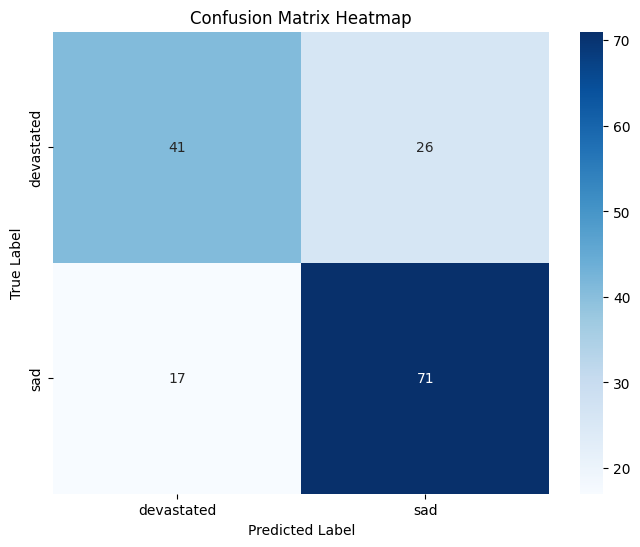

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('devastated', 'sad'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name="bert-base-uncased",  # or your custom model tokenizer
    max_len=96
)


Filtered Training Samples: 1244
Filtered Testing Samples: 163
Label Mapping for this pair: {'anticipating': 0, 'excited': 1}


Map:   0%|          | 0/1244 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1244 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

{'sentiment_score': tensor([4.5200, 8.9600, 8.4000, 9.8300]), 'labels': tensor([1, 0, 0, 0]), 'input_ids': tensor([[  101,  1045,  2031,  1037,  2980,  3058,  2023,  5353,  1012,  2003,
          2009,  2115,  2034,  3058,  2007,  2014,  1029,  2748,  2009,  2097,
          2022,  2073,  2024,  2017,  2635,  2014,  1029,  1045,  2572,  2635,
          2000,  1037,  3185,  1998,  1996,  9724,  3871,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2821,  2158,  1045,  2064,  1005,  1056,  3524,  2000,  2507,
          2026,  2388,  1999,  2375,  2014,  2160, 

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch [1], Batch [0], Loss: 0.5770
Epoch [1], Batch [10], Loss: 0.7095
Epoch [1], Batch [20], Loss: 0.5336
Epoch [1], Batch [30], Loss: 0.6166
Epoch [1], Batch [40], Loss: 0.5480
Epoch [1], Batch [50], Loss: 0.4759
Epoch [1], Batch [60], Loss: 0.5308
Epoch [1], Batch [70], Loss: 0.4872
Epoch [1] complete. Average Loss: 0.5732
Epoch [2], Batch [0], Loss: 0.3994
Epoch [2], Batch [10], Loss: 0.6286
Epoch [2], Batch [20], Loss: 0.6209
Epoch [2], Batch [30], Loss: 0.3618
Epoch [2], Batch [40], Loss: 0.4032
Epoch [2], Batch [50], Loss: 0.4831
Epoch [2], Batch [60], Loss: 0.6242
Epoch [2], Batch [70], Loss: 0.6013
Epoch [2] complete. Average Loss: 0.4879
Epoch [3], Batch [0], Loss: 0.3913
Epoch [3], Batch [10], Loss: 0.2832
Epoch [3], Batch [20], Loss: 0.2859
Epoch [3], Batch [30], Loss: 1.0499
Epoch [3], Batch [40], Loss: 0.6845
Epoch [3], Batch [50], Loss: 0.4719
Epoch [3], Batch [60], Loss: 0.2732
Epoch [3], Batch [70], Loss: 0.3465
Epoch [3] complete. Average Loss: 0.4300
Drive already mo

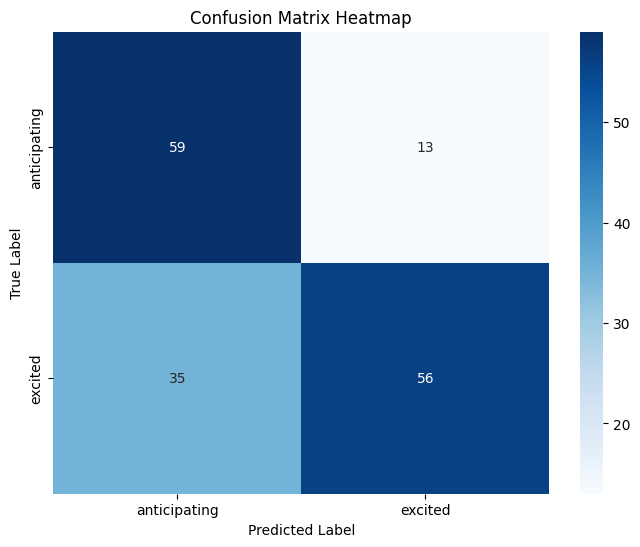

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('excited', 'anticipating'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name='bert-base-uncased',  # or your custom model tokenizer
    max_len=96
)


Filtered Training Samples: 1162
Filtered Testing Samples: 144
Label Mapping for this pair: {'afraid': 0, 'terrified': 1}


Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

{'sentiment_score': tensor([6.0200, 8.6700, 8.5300, 8.5700]), 'labels': tensor([0, 1, 0, 1]), 'input_ids': tensor([[  101,  1045,  2572,  2025,  2583,  2000,  3477,  2005,  2026, 14344,
          1012,  1045,  2228,  1045,  2097,  4558,  2026,  2188,  2821, 10166,
          1010,  2008,  1005,  1055,  2025,  2204,  2012,  2035,  1045,  2113,
          1012,  1045,  2439,  2026,  3105,  2349,  2000, 19309,  1999,  1996,
          2194,  1012,  3398,  1010,  2008,  4165,  2053,  2204,  1010,  2054,
          2097,  2017,  2079,  2085,  1029,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2821,  1045,  2001,  2061,  5513,  1999,  2026,  6879,  1012,
          1045,  2001,  3564,  2648,  2006,  2026, 

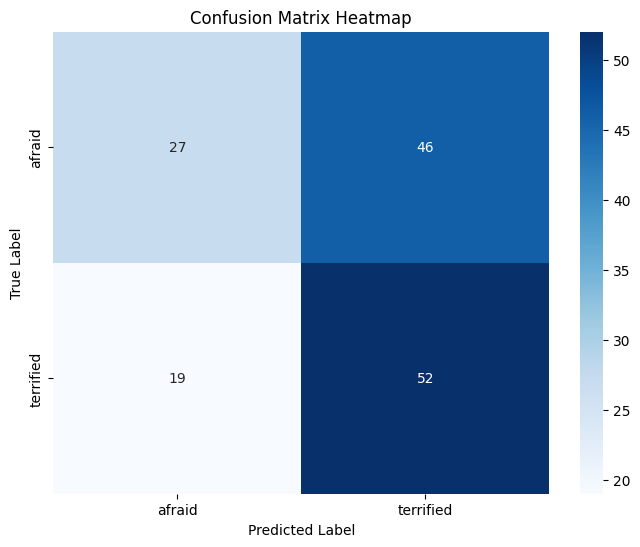

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('afraid', 'terrified'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name="bert-base-uncased",  # or your custom model tokenizer
    max_len=96
)


Filtered Training Samples: 1016
Filtered Testing Samples: 130
Label Mapping for this pair: {'ashamed': 0, 'guilty': 1}


Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

{'sentiment_score': tensor([5.4300, 3.3300, 3.1900, 4.5100]), 'labels': tensor([0, 1, 1, 0]), 'input_ids': tensor([[  101,  1045,  2001,  3788,  2006,  1996,  2346,  1012,  1045,  2387,
          1037, 11693,  6843,  1998,  1045,  2134,  1005,  1056,  2393,  2032,
          1012, 10166,  1010,  2008,  1005,  1055, 17704,  2812,  3398,  1045,
          2113,  1012,  1045,  2001,  1999,  1037,  9241,  1998,  1045,  2572,
         14984,  1997,  2870,   999,   999,  2017,  2228,  2002,  2097,  2022,
          2045,  2279,  2051,  2061,  2017,  2064,  2393,  2032,  1029,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  1045,  8823,  2026,  2522,  1011,  7309,  1005,  1055,  9850,
          1010,  2029,  2001,  1999,  1996, 16716, 

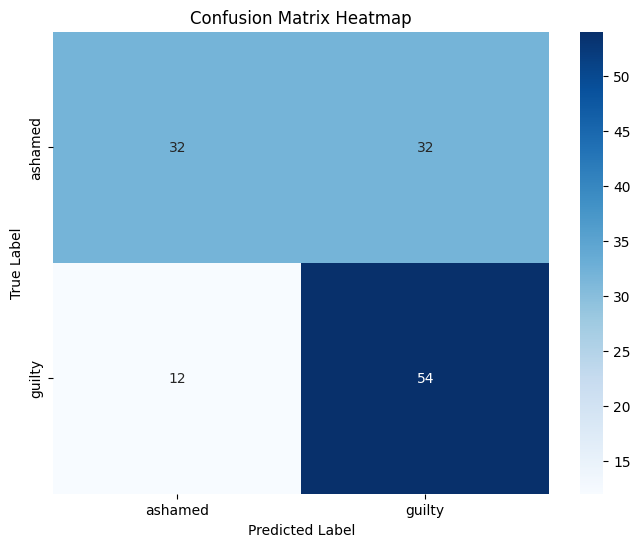

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('ashamed', 'guilty'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name="bert-base-uncased",  # or your custom model tokenizer
    max_len=96
)


Filtered Training Samples: 1015
Filtered Testing Samples: 168
Label Mapping for this pair: {'nostalgic': 0, 'sentimental': 1}


Map:   0%|          | 0/1015 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1015 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

{'sentiment_score': tensor([4.1100, 9.4900, 9.7300, 5.3600]), 'labels': tensor([1, 0, 0, 0]), 'input_ids': tensor([[  101,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,  2026,
          2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,  2412,
          2985,  2051,  2894,  2362,  1012,  2348,  2045,  2001,  1037,  2843,
          1997,  2111,  1010,  2057,  2371,  2066,  1996,  2069,  2111,  1999,
          1996,  2088,  1012,  2001,  2023,  1037,  2767,  2017,  2020,  1999,
          2293,  2007,  1010,  2030,  2074,  1037,  2190,  2767,  1029,  2023,
          2001,  1037,  2190,  2767,  1012,  1045,  3335,  2014,  1012,  2073,
          2038,  2016,  2908,  1029,  2057,  2053,  2936,  2831,  1012,  2821,
          2001,  2023,  2242,  2008,  3047,  2138,  1997,  2019,  6685,  1029,
           102,     0,     0,     0,     0,     0],
        [  101,  1045,  2001,  2583,  2000,  4139,  2039,  2006,  1996,  4274,
          4620,  2013,  2073,  1045,  2973,  2004, 

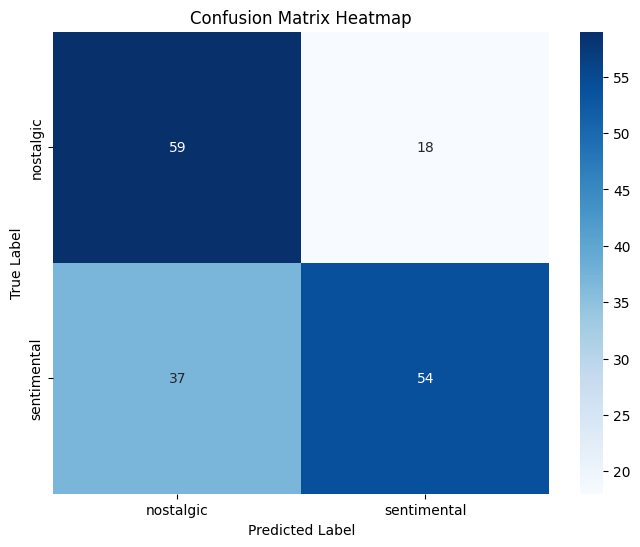

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('sentimental', 'nostalgic'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name="bert-base-uncased",  # or your custom model tokenizer
    max_len=96
)


Filtered Training Samples: 1189
Filtered Testing Samples: 151
Label Mapping for this pair: {'angry': 0, 'furious': 1}


Map:   0%|          | 0/1189 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1189 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

{'sentiment_score': tensor([3.9400, 3.4000, 6.1200, 4.3500]), 'labels': tensor([1, 1, 0, 0]), 'input_ids': tensor([[  101,  1045,  2572,  2061,  5506,  2026,  3462,  2288, 13261,  1012,
          6289,  2008, 19237,  1010,  2017,  2020,  2183,  2005,  2151,  2449,
          3116,  1029,  2748,  1998,  2009,  2001,  2019,  2590,  2028,  1012,
          1045,  3246,  2017,  2134,  1005,  1056,  4558,  2008,  7396,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  1045,  2572,  2061,  5506,  2008,  1045,  9471,  2026,  2769,
          2012,  2188,  1012,  7910,  2821,  1012, 

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch [1], Batch [0], Loss: 0.4213
Epoch [1], Batch [10], Loss: 0.4711
Epoch [1], Batch [20], Loss: 0.5907
Epoch [1], Batch [30], Loss: 0.4954
Epoch [1], Batch [40], Loss: 0.5214
Epoch [1], Batch [50], Loss: 0.4968
Epoch [1], Batch [60], Loss: 0.5126
Epoch [1], Batch [70], Loss: 0.5918
Epoch [1] complete. Average Loss: 0.4877
Validation Loss: 0.6998
Accuracy: 0.4702
Precision: 0.4816
Recall: 0.4702
F1-score: 0.4706
Confusion Matrix:
[[36 48]
 [32 35]]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model weights saved to /content/drive/MyDrive/saved_models/finegrained_furious_angry/pytorch_model.bin
Tokenizer files saved to /content/drive/MyDrive/saved_models/finegrained_furious_angry


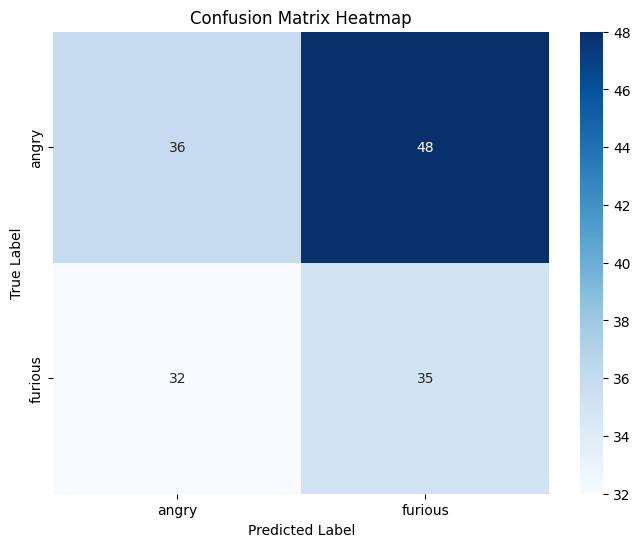

In [ ]:
prepare_emotion_pair_datasets(
    emotion_pair=('furious', 'angry'),
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    tokenizer_name='bert-base-uncased',  # or your custom model tokenizer
    max_len=96
)

In [ ]:
import torch
import os
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# Define your Custom Model again (same architecture as before)
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        hidden_size = self.bert.config.hidden_size  # usually 768
        additional_feature_size = 1  # sentiment_score is a scalar

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get [CLS] representation (first token)
        pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

        # Reshape sentiment_score to (batch_size, 1)
        sentiment_score = sentiment_score.unsqueeze(1)

        # Concatenate
        combined = torch.cat((pooled_output, sentiment_score), dim=1)

        # Dropout + classification
        combined = self.dropout(combined)
        logits = self.classifier(combined)

        return logits

# Set emotion pair (replace with the pair you saved)
emotion_pair = ('devastated', 'sad')

# Define paths (update if needed)
save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{emotion_pair[0]}_{emotion_pair[1]}'
model_path = os.path.join(save_dir, "pytorch_model.bin")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(save_dir)

# Load model with correct label count
num_labels = 2  # Change if needed based on your dataset
model = CustomBERTModel('bert-base-uncased', num_labels)

# Load model weights
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Change to 'cuda' if using GPU

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

print("✅ Model and tokenizer successfully loaded!")




✅ Model and tokenizer successfully loaded!


In [ ]:
# Example sentence for inference
example_text = "you are in a wrong track dear.Real Idiot"

# Tokenize input
inputs = tokenizer(example_text, return_tensors="pt", padding='max_length', truncation=True, max_length=96)
inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device

# Dummy sentiment score (adjust as needed)
sentiment_score = torch.tensor([0.5]).to(device)  # Replace with real sentiment score

# Run inference
with torch.no_grad():
    logits = model(inputs["input_ids"], inputs["attention_mask"], sentiment_score)

# Get predicted label
predicted_label = torch.argmax(logits, dim=1).item()

print(f"Predicted Label: {predicted_label}")


label_mapping = {
    "devastated": 0,
    "sad": 1
}

# Reverse the label mapping
label_mapping_inverse = {v: k for k, v in label_mapping.items()}


# Print the predicted emotion instead of just the numerical label
predicted_emotion = label_mapping_inverse[predicted_label]
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Label: 1
Predicted Emotion: sad


In [ ]:
import torch
import os
from transformers import AutoTokenizer, AutoModel, pipeline
import torch.nn as nn

# Load emotion classifier for sentiment score prediction
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None  # Return all emotion scores
)

# Function to predict sentiment score
def get_emotion_score(text):
    predictions = emotion_classifier(text)[0]
    max_prob = max([pred['score'] for pred in predictions])  # Highest emotion probability
    return round(max_prob * 10, 2)  # Normalize score to scale of 0-10

# Define your Custom Model again (same architecture as before)
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        hidden_size = self.bert.config.hidden_size  # usually 768
        additional_feature_size = 1  # sentiment_score is a scalar

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get [CLS] representation (first token)
        pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

        # Reshape sentiment_score to (batch_size, 1)
        sentiment_score = sentiment_score.unsqueeze(1)

        # Concatenate
        combined = torch.cat((pooled_output, sentiment_score), dim=1)

        # Dropout + classification
        combined = self.dropout(combined)
        logits = self.classifier(combined)

        return logits

# Set emotion pair
emotion_pair = ('devastated', 'sad')

# Define paths
save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{emotion_pair[0]}_{emotion_pair[1]}'
model_path = os.path.join(save_dir, "pytorch_model.bin")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(save_dir)

# Load model with correct label count
num_labels = 2  # Change if needed based on your dataset
model = CustomBERTModel('bert-base-uncased', num_labels)

# Load model weights
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Change to 'cuda' if using GPU

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

print("✅ Model and tokenizer successfully loaded!")

# Example sentence for inference
example_text = "oh my goat. my leg was broken into 3 pieces. Really painful"

# Tokenize input
inputs = tokenizer(example_text, return_tensors="pt", padding='max_length', truncation=True, max_length=96)
inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device

# Predict sentiment score
sentiment_score_value = get_emotion_score(example_text)
sentiment_score_tensor = torch.tensor([sentiment_score_value]).to(device)  # Convert to tensor

print(f"Sentiment Score: {sentiment_score_value}")  # Print sentiment score

# Run inference
with torch.no_grad():
    logits = model(inputs["input_ids"], inputs["attention_mask"], sentiment_score_tensor)

# Get predicted label
predicted_label = torch.argmax(logits, dim=1).item()

print(f"Predicted Label: {predicted_label}")

# Define label mapping
label_mapping = {
    "devastated": 0,
    "sad": 1
}

# Reverse the label mapping
label_mapping_inverse = {v: k for k, v in label_mapping.items()}

# Print the predicted emotion
predicted_emotion = label_mapping_inverse[predicted_label]
print(f"Predicted Emotion: {predicted_emotion}")



Device set to use cpu


✅ Model and tokenizer successfully loaded!
Sentiment Score: 5.01
Predicted Label: 0
Predicted Emotion: devastated
